# Cloud Constable Content-Based Threat Detection
______
### Stephen Camera-Murray, Himani Garg, Vijay Thangella
## Wikipedia Personal Attacks corpus
(https://figshare.com/articles/Wikipedia_Detox_Data/4054689)

115,864 verbatims out of which 13,590 are labelled aggressive and 102,274 are not.

Aggressive Speech                                      |  Normal Speech
:-----------------------------------------------------:|:------------------------------------------------------:
<img src="thumbsdown.png" alt="Aggressive" style="width: 200px;"/> | <img src="thumbsup.png" alt="Normal" style="width: 200px;"/>

### Step 2 - Feature Extraction and Analysis
____

#### Import required libraries

In [1]:
#import libraries
import numpy as np
import pandas as pd
import nltk
import pickle
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

#### Load Clean Dataframe

In [3]:
# load the labels file
verbatimsDF = pd.read_csv ('data/cleansedVerbatims.tab.gz', compression='gzip', sep='\t')
verbatimsDF.head()

,content,aggressive
0,this is not creative those are the dictionary...,0.0
1,the term standard model is itself less npov t...,0.0
2,true or false the situation as of march was s...,0.0
3,next maybe you could work on being less conde...,0.0
4,this page will need disambiguation,0.0


#### Apply Stemming
Let's go back to this one later.

In [3]:
#TBD

#### Feature Extraction
We start with word vectorization of each email's text with a simple bag of words approach. We should test whether or not n-gram frequencies or character-based analysis might yield improvements.

In [4]:
# set up the vectorizer
vectorizer = CountVectorizer(stop_words='english') # remove stopwords and go with mostly defaults for now
verbatimsVec = vectorizer.fit_transform(verbatimsDF['content'])

print ( 'The vectorized counts have', '{:,}'.format ( verbatimsVec.shape[0] ), 'rows and', '{:,}'.format ( verbatimsVec.shape[1] ), 'features.' )

The vectorized counts have 115,864 rows and 139,241 features.


Yikes, 139K features might be a bit much to keep, unless we do PCR to trim it down or keep them all for deep learning later. Let's have a look at some of these features to see that they're even worth keeping.

In [5]:
vectorizer.get_feature_names()

['aa',
 'aaa',
 'aaaa',
 'aaaaa',
 'aaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaany',
 'aaaaaaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhh',
 'aaaaaaaaaah',
 'aaaaaaaaaahhhhhhhhhhhhhh',
 'aaaaaaaaadm',
 'aaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh',
 'aaaaaaaari',
 'aaaaaaaayui',
 'aaaaah',
 'aaaannnnyyyywwwwhhhheeeerrrreeee',
 'aaaawwww',
 'aaabbccz',
 'aaaboyz',
 'aaages',
 'aaagh',
 'aaah',
 'aaahh',
 'aaahhh',
 'aaahs',
 'aaai',
 'aaand',
 'aaargh',
 'aaarrrgggh',
 'aaas',
 'aab',
 'aabb',
 'aabi',
 'aac',
 'aacademic',
 'aacenc',
 'aachen',
 'aachi',
 'aachttps',
 'aad',
 'aademia',
 'aadhe',
 'aadmi',
 'aadministrators',
 'aadt',
 'aadu',
 'aaets',
 'aaf',
 'aaffect',
 'aafia',
 'aaflight',
 'aafuss',
 'aag',
 'aage',
 'aagin',
 'aah',
 'aahank',
 'aahh',
 'aahoa',
 'aai',
 'aaib',
 'aake',
 'aaker',
 '

Hmm, I'm not sure much of this will help. Let's bring that down to something more reasonable like the top 3K features.

In [6]:
# set up the vectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=3000) # keep only the top 3K features
verbatimsVec = vectorizer.fit_transform(verbatimsDF['content'])

print ( 'The vectorized counts have', '{:,}'.format ( verbatimsVec.shape[0] ), 'rows and', '{:,}'.format ( verbatimsVec.shape[1] ), 'features.' )

The vectorized counts have 115,864 rows and 3,000 features.


Let's try that again and we see that our features now make more sense.

In [7]:
vectorizer.get_feature_names()

['ability',
 'able',
 'absolute',
 'absolutely',
 'absurd',
 'abuse',
 'abusing',
 'abusive',
 'academic',
 'accept',
 'acceptable',
 'accepted',
 'access',
 'according',
 'account',
 'accounts',
 'accuracy',
 'accurate',
 'accurately',
 'accusation',
 'accusations',
 'accuse',
 'accused',
 'accusing',
 'achieve',
 'acknowledge',
 'act',
 'acting',
 'action',
 'actions',
 'active',
 'activities',
 'activity',
 'actor',
 'acts',
 'actual',
 'actually',
 'ad',
 'add',
 'added',
 'adding',
 'addition',
 'additional',
 'additionally',
 'additions',
 'address',
 'addressed',
 'addresses',
 'addressing',
 'adds',
 'admin',
 'administration',
 'administrative',
 'administrator',
 'administrators',
 'admins',
 'admit',
 'admitted',
 'adopted',
 'advance',
 'advertising',
 'advice',
 'advise',
 'afd',
 'afghanistan',
 'afraid',
 'africa',
 'african',
 'age',
 'agenda',
 'agf',
 'aggressive',
 'ago',
 'agree',
 'agreed',
 'agreement',
 'ah',
 'ahead',
 'aids',
 'aidsaids',
 'ain',
 'air',
 'airc

#### Visualize the Dataset
Great, now let's visualize the vectorized data in another way as a sanity check to be sure that we didn't goof anything along the way.

In [8]:
# Sum up the counts of each vocabulary word for spam and ham
normalCounts     = np.squeeze(np.asarray(np.sum(verbatimsVec[verbatimsDF[verbatimsDF["aggressive"]==0].index], axis=0)))
aggressiveCounts = np.squeeze(np.asarray(np.sum(verbatimsVec[verbatimsDF[verbatimsDF["aggressive"]==1].index], axis=0)))

# Clean up our set into a tidy dataframe
wordCounts = pd.DataFrame({'word':vectorizer.get_feature_names(), 'normal_counts':normalCounts, 'aggressive_counts':aggressiveCounts, 'aggressive_count_delta':(aggressiveCounts-normalCounts)})
wordCounts.head()

,aggressive_count_delta,aggressive_counts,normal_counts,word
0,-400,26,426,ability
1,-1462,89,1551,able
2,-169,32,201,absolute
3,-730,89,819,absolutely
4,-216,21,237,absurd


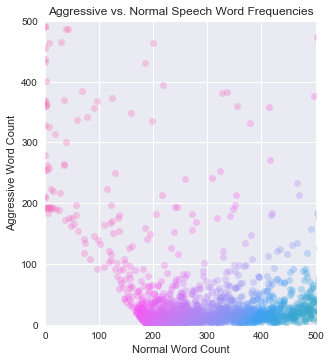

In [10]:
# set up our scatter plot with a diverging color palette to show extreme count differences
sns.set(color_codes=True)
scatter = sns.lmplot(x="normal_counts", y="aggressive_counts", data=wordCounts, fit_reg=False, scatter_kws={'alpha':0.3},legend=False,hue="aggressive_count_delta")

# trim down the plot so we can see most of the dataset
plt.xlim(0,500)
plt.ylim(0,500)

scatter.set(xlabel='Normal Word Count', ylabel='Aggressive Word Count', title='Aggressive vs. Normal Speech Word Frequencies')
plt.show()

Each observation represents a word with its word count for normal speech on the x-axis and aggressive speech on the y-axis. In addtion, the datapoints are colored magenta where there's a stronger difference favoring aggressive speech and blue for normal. Lots of observations clustered around a 45 degree line would suggest that word count variations would not be a good feature set for prediction, but luckily this is not the case. We see lots of good word count variations between spam and ham emails.

Note: This isn't quite right, we should make this a percentage since the data is imbalanced.

Great, let's clean up and write out word count summaries in case we'll need them later and save our final email features dataframe for the next step.

In [12]:
# Clean up our features set into a tidy dataframe
wordCounts = pd.DataFrame(verbatimsVec.toarray(), columns=vectorizer.get_feature_names()) # convert vectors to a dataframe
verbatimFeatures = pd.concat([verbatimsDF["aggressive"], wordCounts], axis=1) # append the vectors to the labels

print ( 'The final features dataframe has', '{:,}'.format ( verbatimFeatures.shape[0] ), 'rows and', '{:,}'.format (  verbatimFeatures.shape[1] - 1 ), 'features + 1 label.' )

The final features dataframe has 115,864 rows and 3,000 features + 1 label.


In [13]:
# write the cleansed dataframe, dictionary, and sums to files
verbatimFeatures.to_csv('data/verbatimFeatures.tab.gz', index=False, compression='gzip', sep='\t')
wordCounts.to_csv('data/wordCountSums.tab.gz', index=False, compression='gzip', sep='\t')

# use pickle to store the dictionary
with open("dictionary.pkl", "wb") as fp:
    pickle.dump ( vectorizer.get_feature_names(), fp )